# BostonHousing MLP 모델 구현
## 기계학습(02)
#### 20213013 컴퓨터공학과 김어진

## 데이터 로드 및 정규화

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# CSV 파일 로드 
df_data = pd.read_csv('C:\\Users\\chosun\\Downloads\\BostonHousing.csv') 


In [15]:
# 데이터 로드 및 전처리
def load_and_preprocess_data(file_path):
    df_data = pd.read_csv(file_path)

    # 특성 선택 (RM, LSTAT, DIS 포함)
    X = df_data[['RM', 'LSTAT', 'DIS']].values
    y = df_data['MEDV'].values

    # 데이터 분할 (80% 학습, 20% 검증)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # z-score 정규화
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    return X_train, X_val, y_train, y_val

## 활성화 함수

In [16]:
# 손실 함수 (MSE + L2 Regularization)
def compute_loss(output, y_true, model, lambda_reg=0.01):
    mse_loss = np.mean((output - y_true) ** 2)
    l2_loss = lambda_reg * (np.sum(np.square(model.weights1)) + np.sum(np.square(model.weights2)))
    return mse_loss + l2_loss

## 은닉층 추가

In [18]:
# MLP 모델 정의
class MLP:
    def __init__(self, input_size, hidden_units, dropout_rate=0.5):
        self.input_size = input_size
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate

        # 가중치 초기화
        self.weights1 = np.random.randn(input_size, hidden_units) * 0.01
        self.bias1 = np.zeros((1, hidden_units))
        self.weights2 = np.random.randn(hidden_units, 1) * 0.01
        self.bias2 = np.zeros((1, 1))

    # 순전파 (forward pass)
    def forward(self, X):
        self.Z1 = np.dot(X, self.weights1) + self.bias1
        self.A1 = np.maximum(0, self.Z1)  # ReLU 활성화 함수
        self.A1 = self.dropout(self.A1)   # 드롭아웃 적용
        self.Z2 = np.dot(self.A1, self.weights2) + self.bias2
        self.output = self.Z2  # 출력층 활성화 없음 (회귀 문제)

        return self.output

    # 드롭아웃 적용
    def dropout(self, A):
        mask = np.random.binomial(1, 1 - self.dropout_rate, size=A.shape)
        return A * mask

    # 역전파 (backward pass)
    def backward(self, X, y):
        m = X.shape[0]
        dZ2 = self.output - y
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        dA1 = np.dot(dZ2, self.weights2.T)
        dZ1 = dA1 * (self.Z1 > 0)  # ReLU 미분

        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        # L2 Regularization 추가
        lambda_reg = 0.01
        dW1 += 2 * lambda_reg * self.weights1
        dW2 += 2 * lambda_reg * self.weights2

        gradients = {
            'dW1': dW1,
            'db1': db1,
            'dW2': dW2,
            'db2': db2
        }
        return gradients

    # 가중치 업데이트
    def update_weights(self, gradients, learning_rate):
        self.weights1 -= learning_rate * gradients['dW1']
        self.bias1 -= learning_rate * gradients['db1']
        self.weights2 -= learning_rate * gradients['dW2']
        self.bias2 -= learning_rate * gradients['db2']

## 데이터 훈련

In [19]:
# 학습 함수
def train_model(model, X_train, y_train, epochs, batch_size, learning_rate):
    loss_history = []
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # 순전파
            output = model.forward(X_batch)

            # 손실 계산
            loss = compute_loss(output, y_batch, model)

            # 역전파
            gradients = model.backward(X_batch, y_batch)

            # 가중치 업데이트
            model.update_weights(gradients, learning_rate)

        loss_history.append(loss)
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

    return loss_history

## 모델 평가

In [20]:
# 평가 함수
def evaluate_model(model, X_val, y_val):
    val_output = model.forward(X_val)
    val_loss = compute_loss(val_output, y_val, model)
    print(f"최종 검증 손실 (MSE): {val_loss:.4f}")
    return val_loss

In [22]:
# 그래프 출력
def plot_loss(loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.grid(True)
    plt.show()


# 학습 및 평가 실행 코드
file_path = 'C:\\Users\\chosun\\Downloads\\BostonHousing.csv'
X_train, X_val, y_train, y_val = load_and_preprocess_data(file_path)

input_size = X_train.shape[1]
hidden_units = 64
learning_rate = 0.001
epochs = 1000
batch_size = 16

# 모델 초기화 및 학습
model = MLP(input_size, hidden_units, dropout_rate=0.5)
loss_history = train_model(model, X_train, y_train, epochs, batch_size, learning_rate)

# 평가 및 그래프 출력
evaluate_model(model, X_val, y_val)
plot_loss(loss_history)

ValueError: shapes (16,16) and (1,64) not aligned: 16 (dim 1) != 1 (dim 0)

## 결과

최종 검증 손실 (MSE): 535.0715


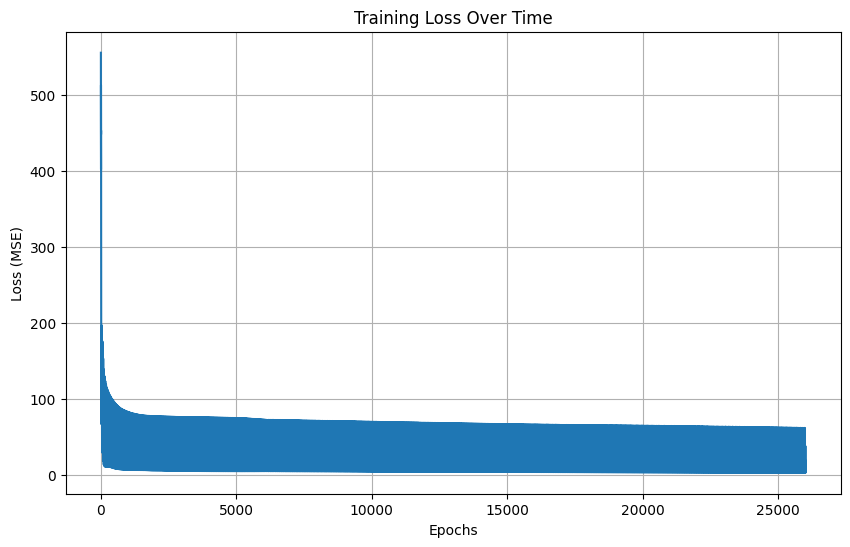

In [24]:
# 그래프 출력
def plot_loss(loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.grid(True)
    plt.show()
    
# 평가 및 그래프 출력
evaluate_model(model, X_val, y_val)
plot_loss(loss_history)
